<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd              
import numpy as np              
import os
import warnings

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font1 = fm.FontProperties(size=20)
font2 = fm.FontProperties(size=24)

%matplotlib inline

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=2)
warnings.filterwarnings(action="ignore")

In [2]:
meteo = pd.read_parquet('../../donnees/temperatures.gzip', engine='pyarrow')
meteo.head()

,,,,,janv.,févr.,mars,avr.,mai,juin,juill.,août,sept.,oct.,nov.,déc.
Nom,Latitude,Longitude,Altitude,Zone,,,,,,,,,,,,
Abbeville,50.136000,1.834000,69,NO,4.506655,5.177926,7.187374,9.897527,12.944717,15.927296,17.647393,17.950155,15.357589,12.012794,7.906183,5.095252
Ajaccio,41.918000,8.792667,5,SE,9.013655,9.098936,10.988942,13.637566,17.484245,21.511102,23.863274,23.911528,20.787859,17.452011,13.180196,10.003745
Alencon,48.445500,0.110167,143,NO,4.579525,5.122644,7.419778,10.159313,13.537345,16.898559,18.620894,18.550157,15.467162,11.902327,7.772221,4.985914
Bale,47.614333,7.510000,263,NE,2.157652,3.353058,6.649048,10.686277,14.948834,18.782333,20.190336,19.770608,15.432660,11.191408,6.100353,2.917112
Bastia,42.540667,9.485167,10,SE,9.188277,9.326488,11.185525,13.803358,17.862716,22.039493,24.835508,24.852453,21.187113,17.405394,13.241846,10.128839


In [3]:
x = meteo.values
ville = meteo.reset_index().Nom

In [4]:
from sklearn.preprocessing import scale
x = scale(x)

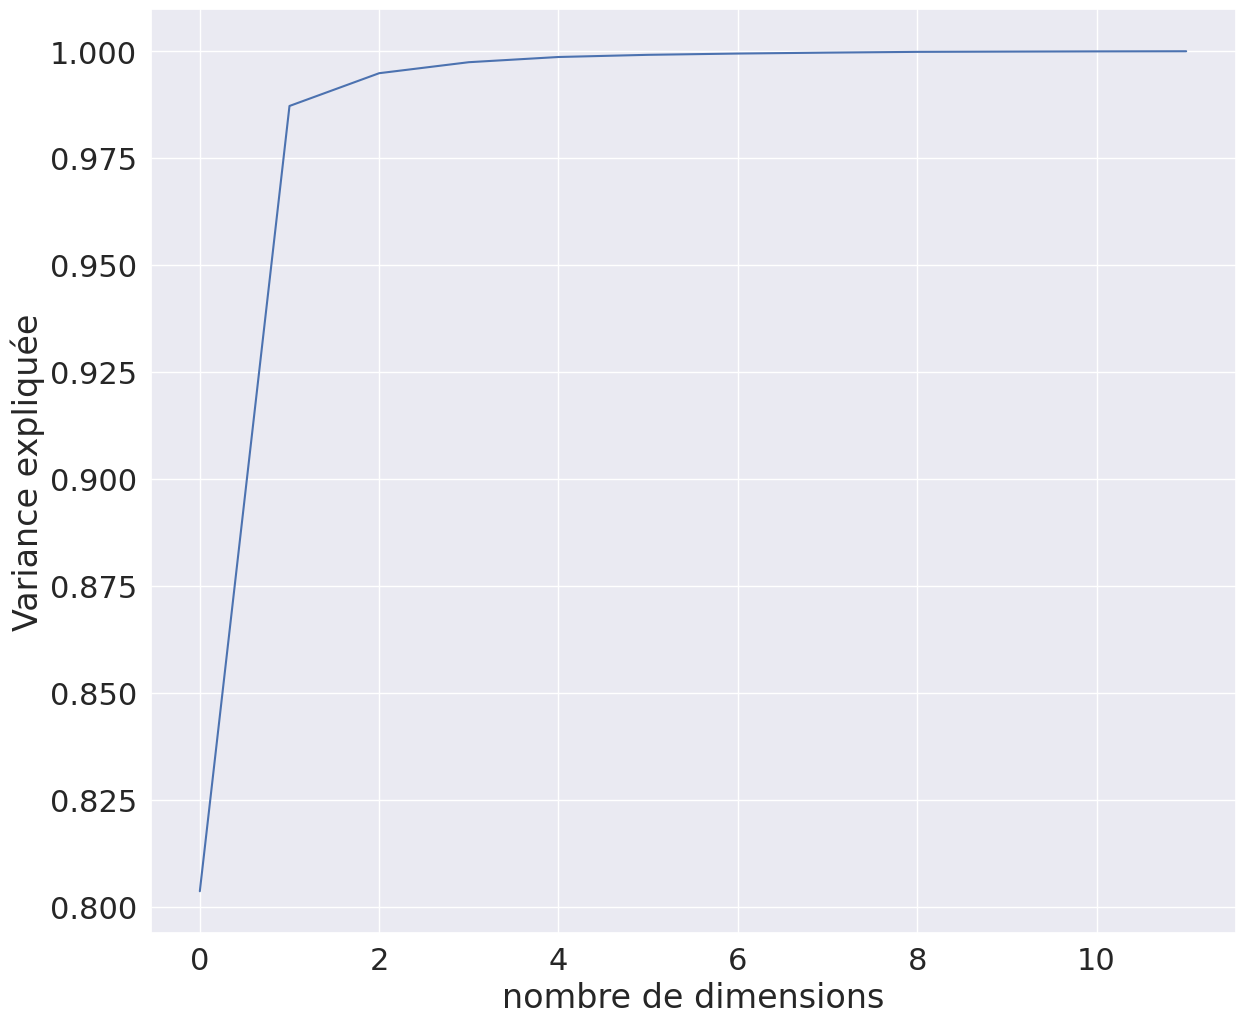

In [5]:
from sklearn.decomposition import PCA
pca = PCA().fit(x)
plt.figure(figsize=(14,12))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('nombre de dimensions')
plt.ylabel('Variance expliquée');

In [6]:
pca.explained_variance_ratio_.cumsum()*100

array([ 80.36682031,  98.72083494,  99.48687761,  99.74398974,
        99.86563601,  99.91657411,  99.94622427,  99.96772889,
        99.98561428,  99.99166929,  99.99672707, 100.        ])

In [7]:
nb_comp = sum(pca.explained_variance_ratio_.cumsum()*100 <= 95) + 1
nb_comp

2

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=nb_comp)
x_red = pca.fit(x).transform(x)
dfPCA = pd.DataFrame(data=x_red, columns=[f'Dim{i+1:02d}'for i in range(nb_comp)])
dfPCA['Ville']= ville
dfPCA.head()

,Dim01,Dim02,Ville
0,2.980559,1.073546,Abbeville
1,-5.577335,0.415928,Ajaccio
2,2.506433,0.496303,Alencon
3,2.887746,-1.945028,Bale
4,-6.142379,0.039631,Bastia


<Figure size 640x480 with 0 Axes>

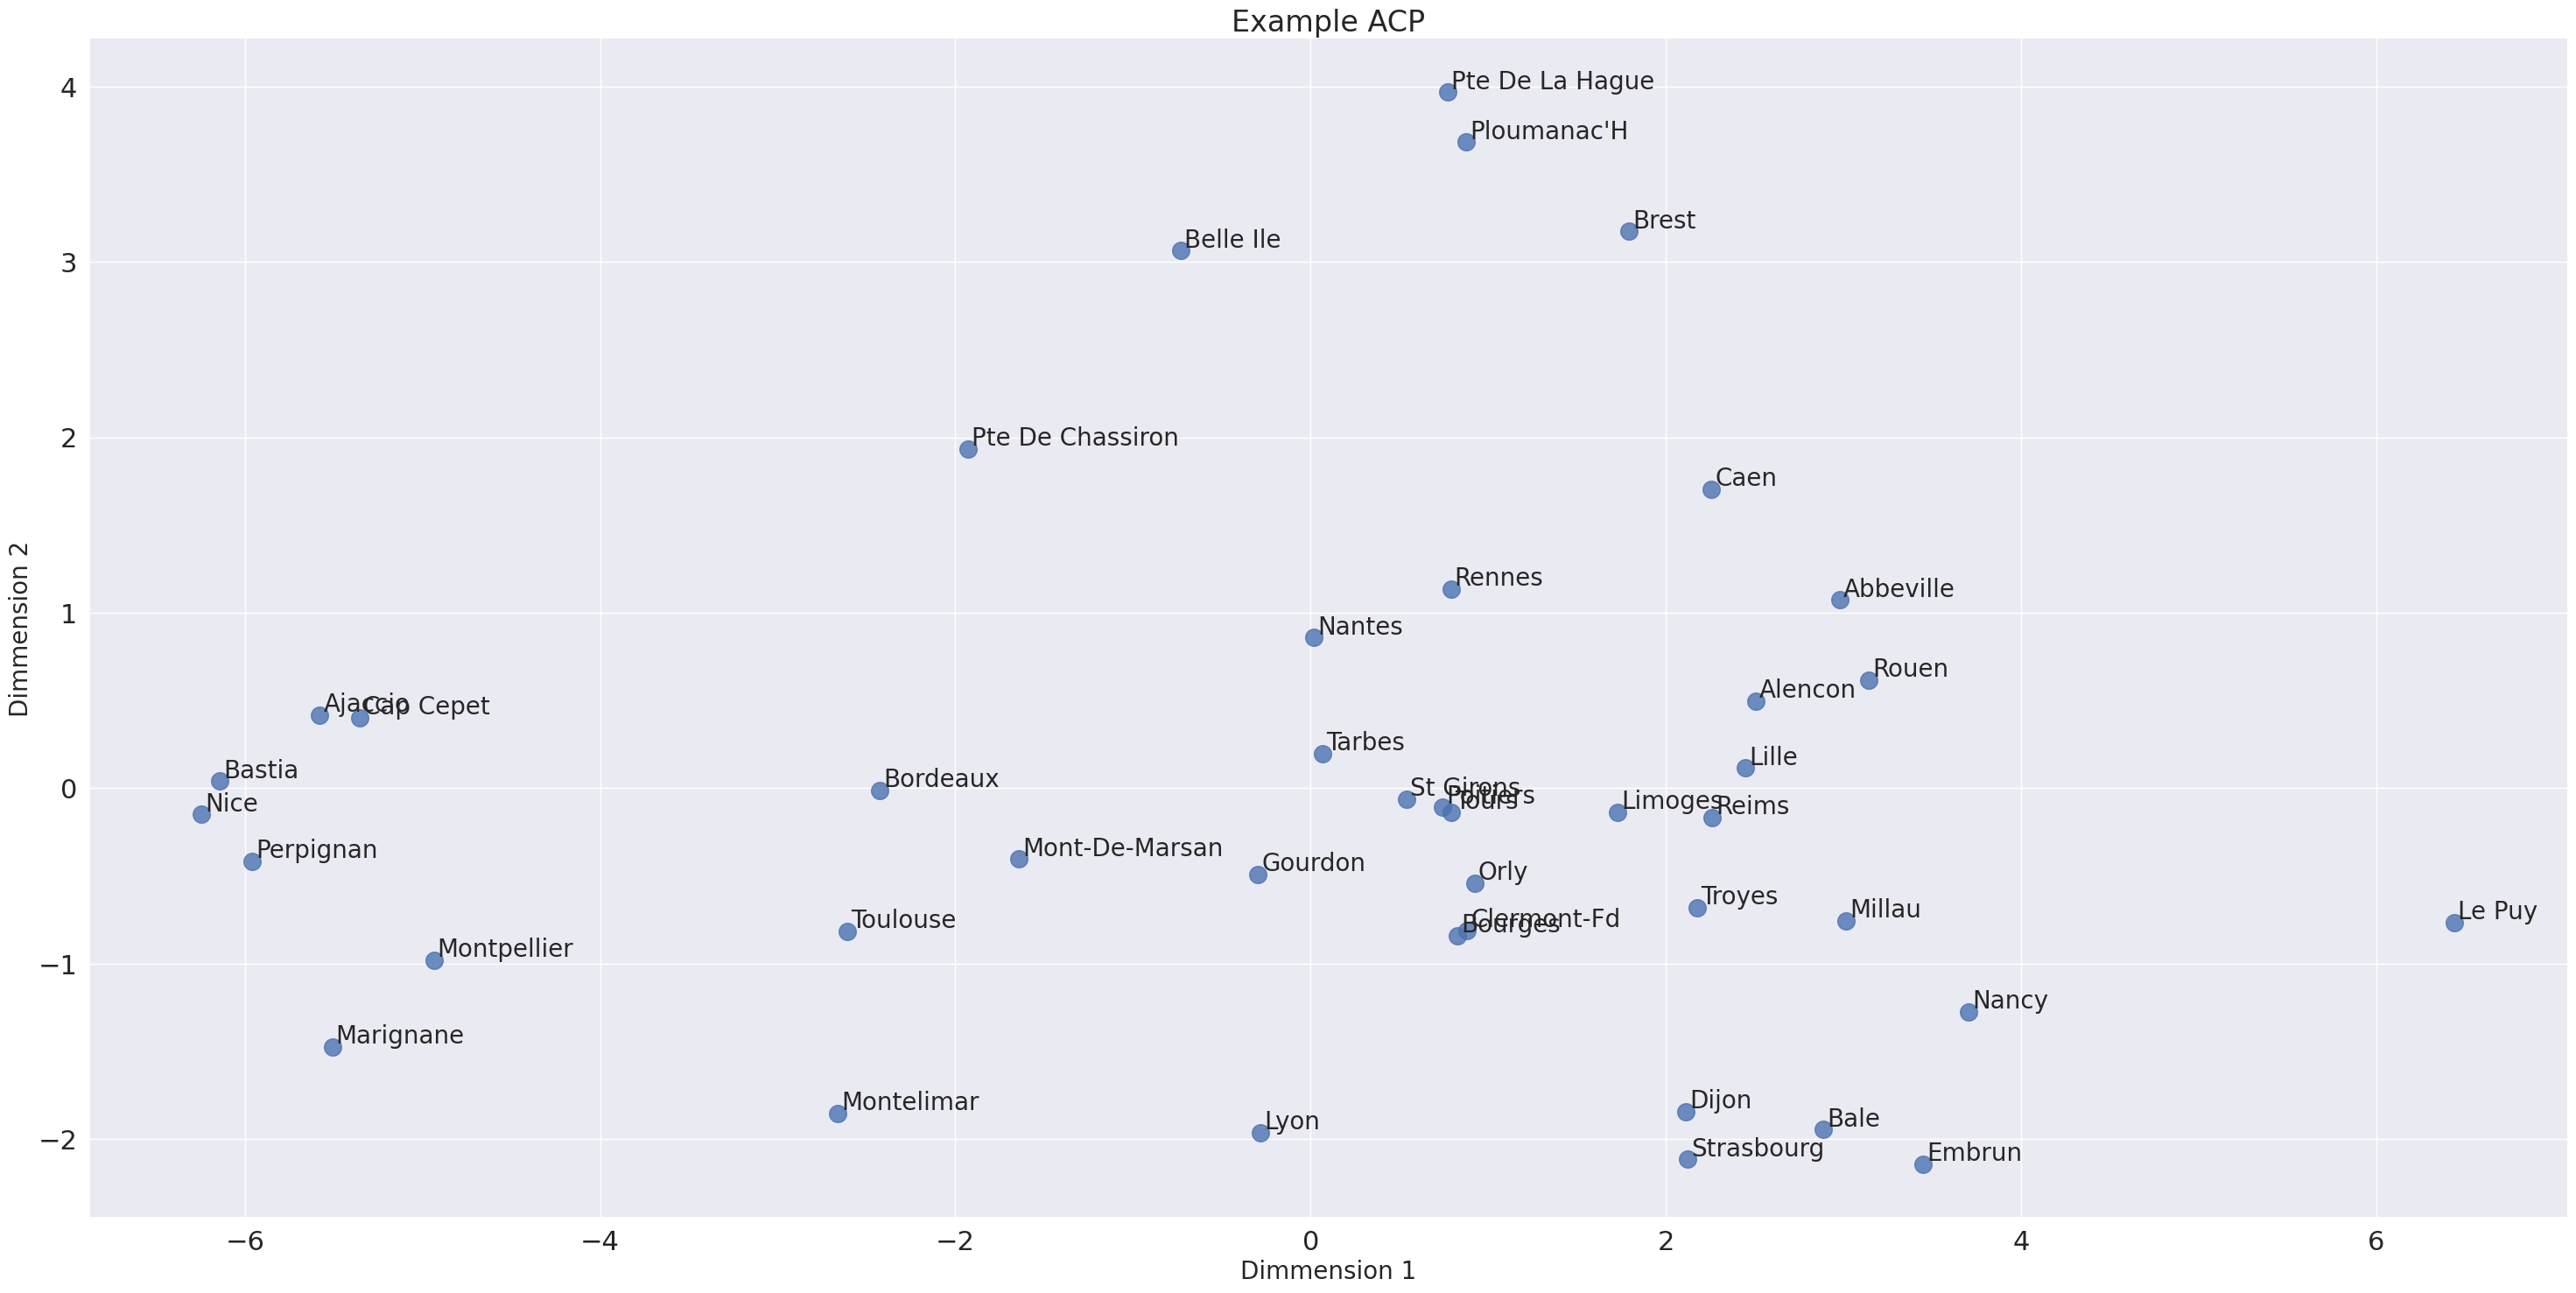

In [9]:
plt.figure()

ax = sns.lmplot(x='Dim01',y='Dim02', data=dfPCA, fit_reg=False, height=15, aspect=2,scatter_kws={"s": 200}) 

plt.title('Example ACP', fontproperties=font2)
plt.xlabel('Dimmension 1', fontproperties=font1)
plt.ylabel('Dimmension 2', fontproperties=font1)


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y']+.02, str(point['val']), fontproperties=font1)

label_point(dfPCA.Dim01, dfPCA.Dim02, dfPCA.Ville, plt.gca())

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage
#Z = linkage(dfPCA.iloc[:,0:5], 'ward')
#Z = linkage(dfPCA.iloc[:,:-1], 'ward')
Z = linkage(dfPCA.drop(columns='Ville'), 'ward')
#Z = linkage(dfPCA.iloc[:,:5], 'ward')


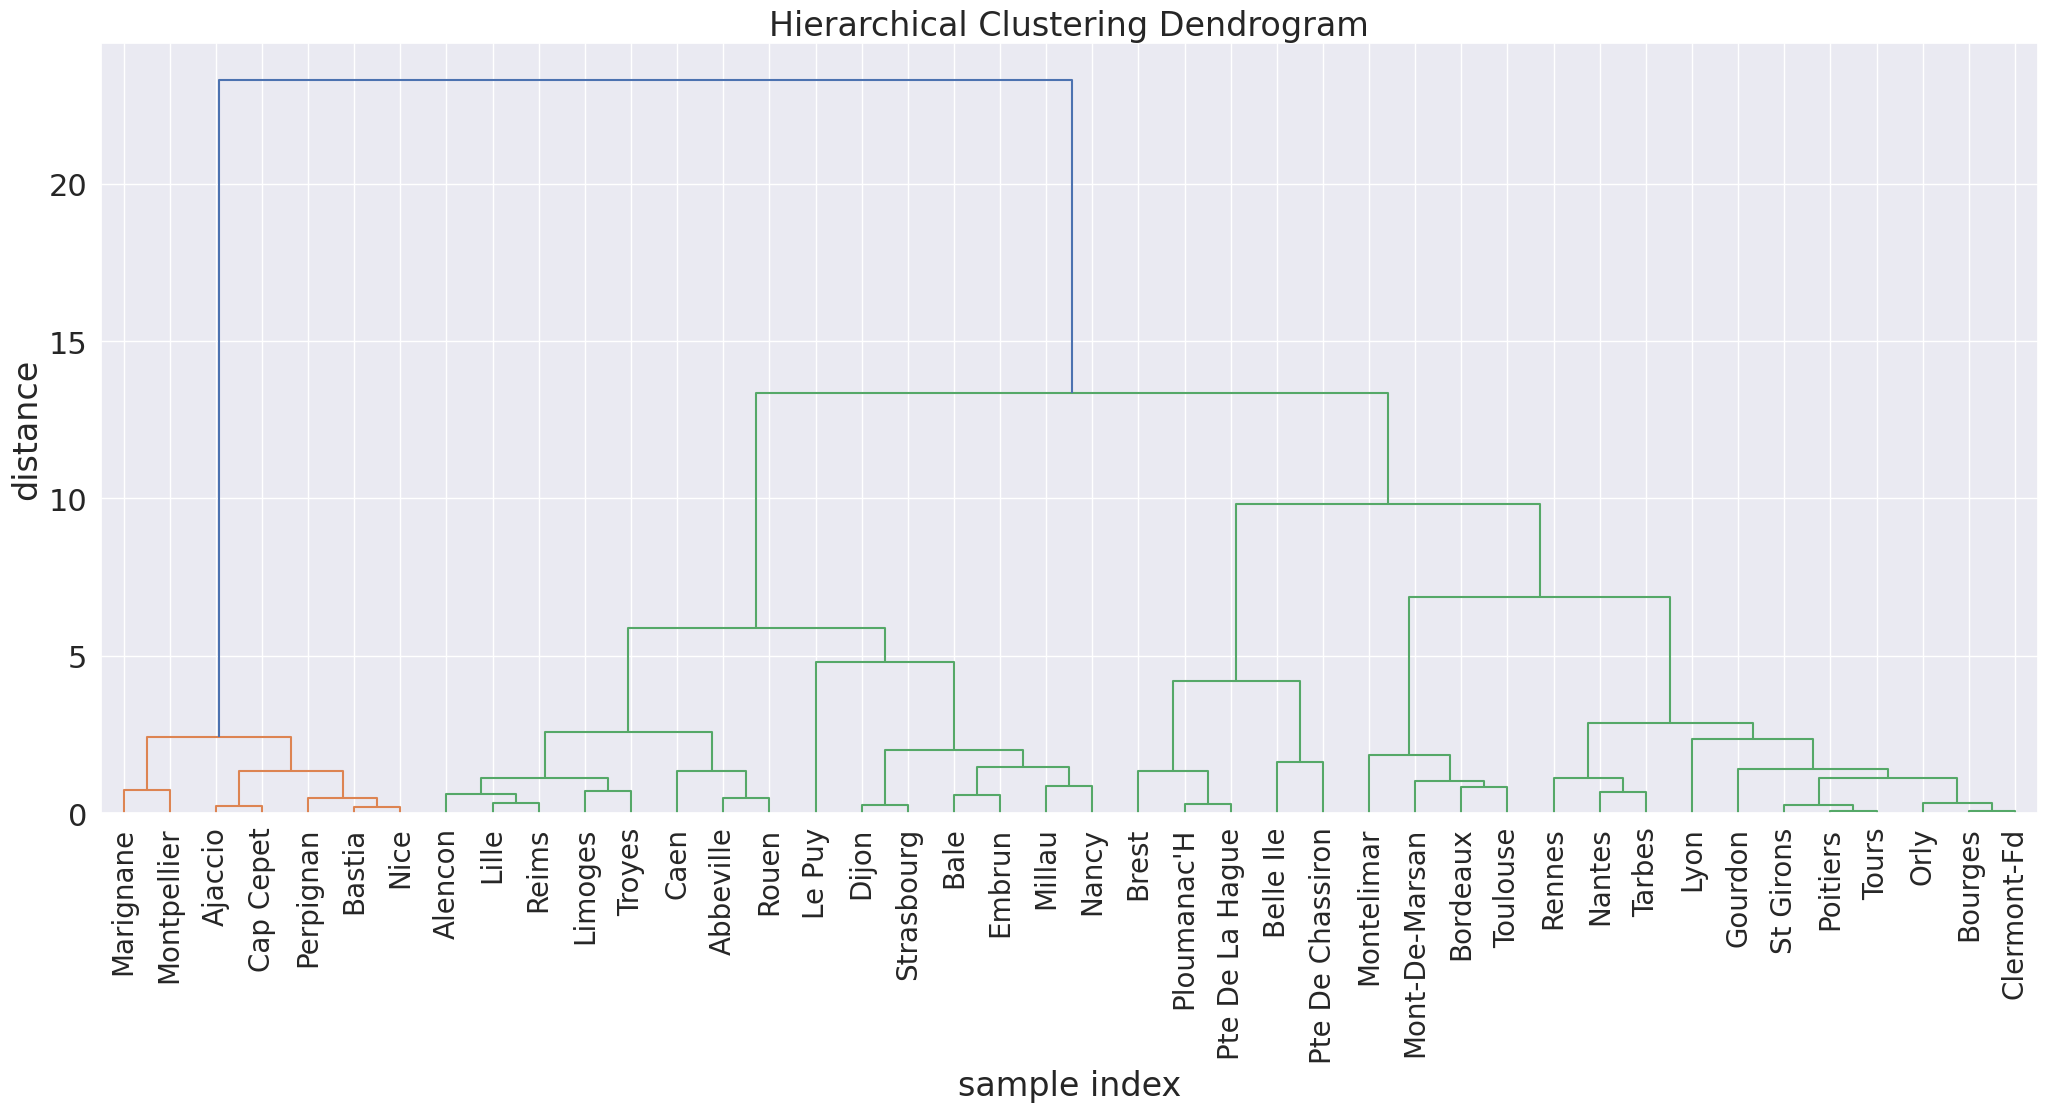

In [11]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram( Z,leaf_rotation=90.,leaf_font_size=20.,
           labels = dfPCA.Ville.values)
plt.show()

In [12]:
def afficheDendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

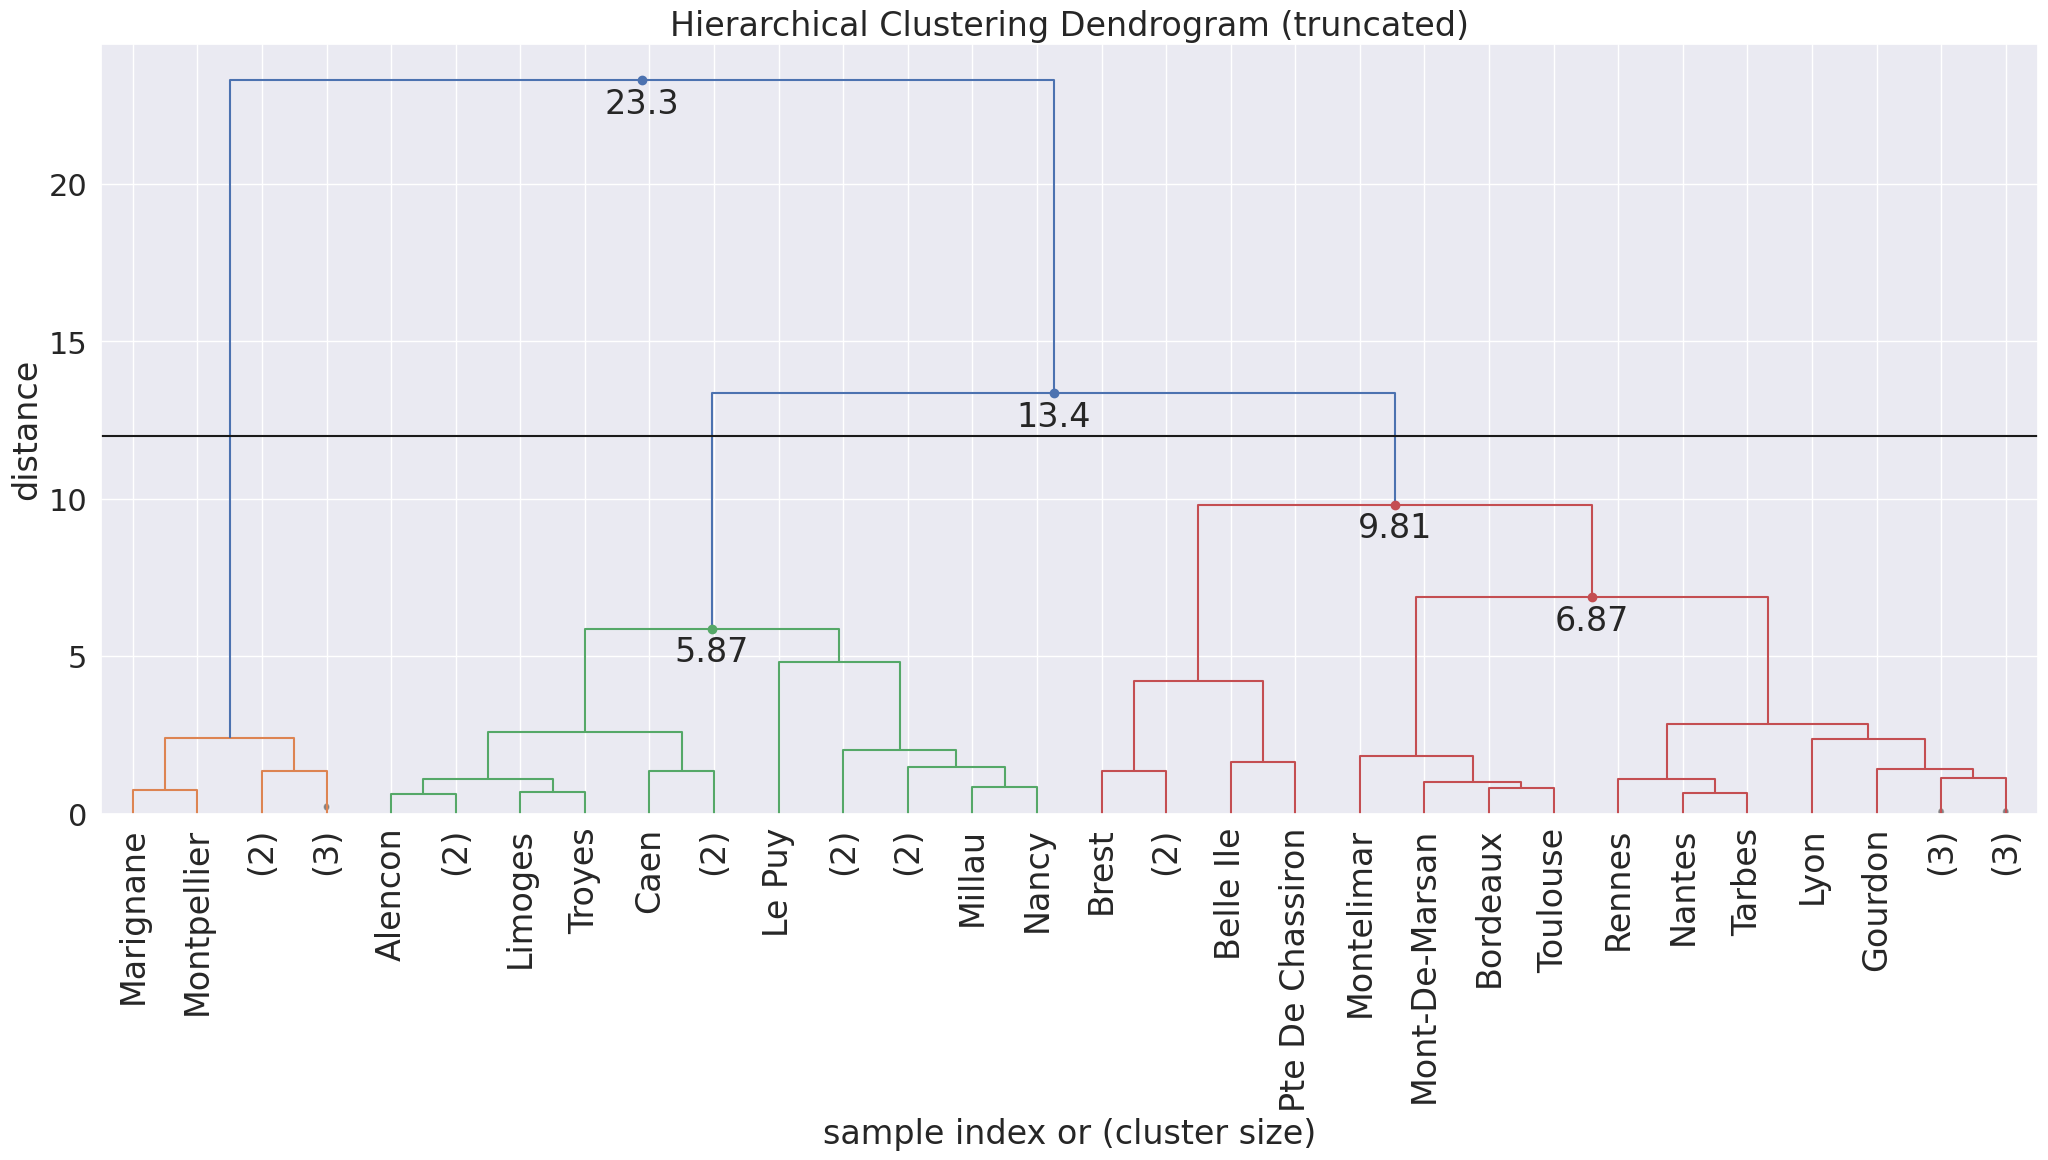

In [16]:
plt.figure(figsize=(25, 10))
afficheDendrogram(
    Z,
    truncate_mode='lastp',
    #p=12,
    leaf_rotation=90.,
    leaf_font_size=24.,
    show_contracted=True,
    annotate_above=5,  # useful in small plots so annotations don't overlap
    labels = dfPCA.Ville.values,
    max_d=12,
)
plt.show()

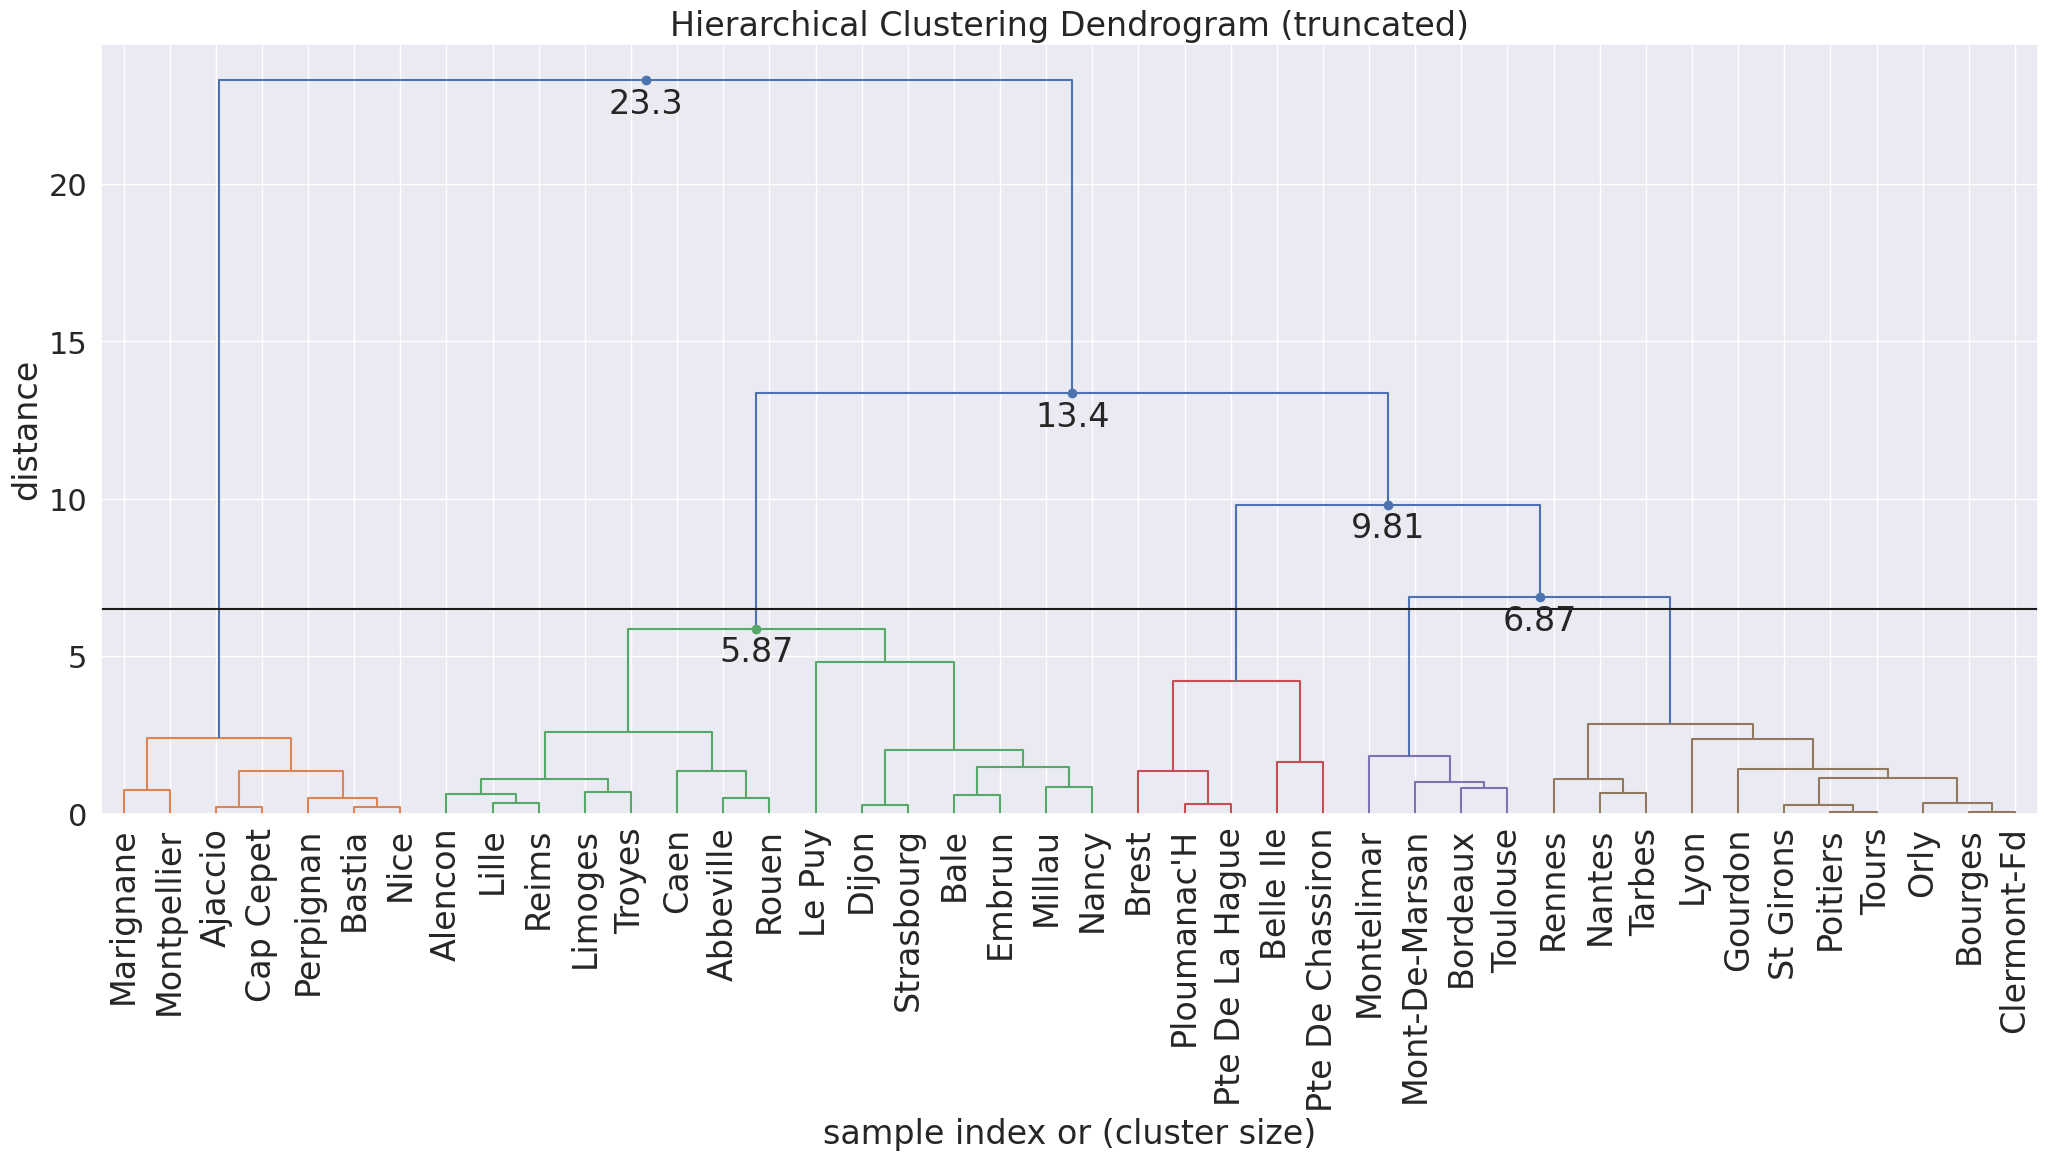

In [18]:
plt.figure(figsize=(25, 10))
afficheDendrogram(
    Z,
    truncate_mode='lastp',
    p=42,
    leaf_rotation=90.,
    leaf_font_size=24.,
    show_contracted=True,
    annotate_above=5,  # useful in small plots so annotations don't overlap
    labels = dfPCA.Ville.values,
    max_d=6.5,
)
plt.show()